# Esame di Tecniche di rappresentazione e modellizzazione dati

Matteo Falasca

Prof.ri:
    Alexandro Saro,
    Milena Valentini,
    Matteo Costanzi
    
Università degli studi di Trieste


## Introduzione
In questo Notebook, è commentato ed esposto il codice relativo alla consegna d'esame 'COVID-19'. L'esposizione sarà così divisa:

1. Esposizione del problema e visualizzazione dati;
2. Implementazione e spiegazione modelli epidemiologici;
3. Analisi Bayesiana Sequenziale dei dati, rispettivamente sui primi 35 e 100 giorni di epidemia;
4. Modellizzazione di diversi intervalli temporali.

Il lavoro è documentato nelle celle Markdown, mentre è commentato all'interno del codice stesso.

Lo scopo del Notebook è di esporre il codice in modo sintetico e utile per futuri lavori.

Il codice è scritto su JupyterNotebook con Python.



## Esposizione del problema e visualizzazione dati

Durante la propagazione del virus Covid-19 è stato utile analizzare l'andamento dei contagi, per poter disporre delle migliori misure di contenimento del virus.

Il primo passo per farlo è visualizzare la curva dei nuovi contagi, per capire in che modo si diffonde il virus. I dati relativi ai nuovi contagi sono stati scaricati dal sito della protezione civile e si trovano anche nella rep di GitHub.

Di seguito è visualizzato l'andamento dei contagi da covid dal 24 febbraio 2020 ad oggi. I nuovi contagi sono rappresentati in un grafico a punti e linee in cui ogni punto rappresenta una settimana diversa.



In [2]:
#Qui vengono installate e implementate le librerie necessarie.

!pip install emcee
!pip install corner
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import poisson
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import emcee
from scipy.optimize import minimize
import math as mth
from scipy.special import gamma
import os

                     data  nuovi_positivi
5     2020-02-24 18:00:00               0
26    2020-02-25 18:00:00               0
47    2020-02-26 18:00:00               0
68    2020-02-27 18:00:00               0
89    2020-02-28 18:00:00               0
...                   ...             ...
30686 2024-02-24 17:00:00               4
30707 2024-02-25 17:00:00               1
30728 2024-02-26 17:00:00               4
30749 2024-02-27 17:00:00               3
30770 2024-02-28 17:00:00               5

[1466 rows x 2 columns]


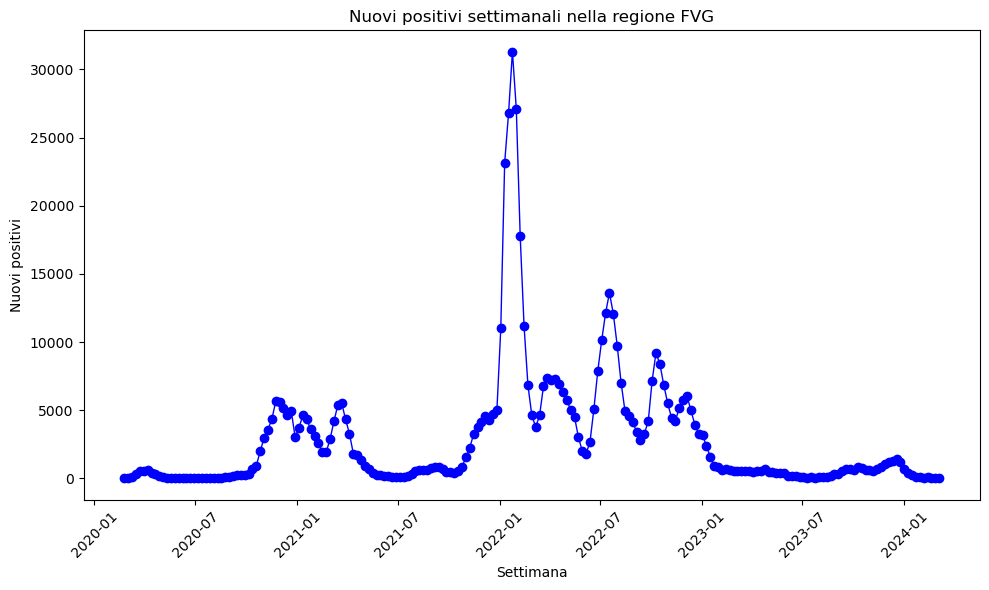

In [3]:
#Qui vengono letti e verificati i dati relativi ai nuovi contagi


'''Leggo e filtro i dati che mi servono, specificando il formato di questi per evitare errori'''


# Leggi il file covid
df = pd.read_csv(r'C:\Users\Matteo\Desktop\Dati1.csv')

# Filtra i dati del FVG
df_fvg = df[df['denominazione_regione'] == 'Friuli Venezia Giulia']

# Salva solo le colonne con data e nuovi positivi 
df_fvg = df_fvg[['data', 'nuovi_positivi']]

# Specifica che la colonna data contiene dati in formato datatime
df_fvg['data'] = pd.to_datetime(df_fvg['data'])

# Verifichiamo di aver preso i dati giusti (Beh... a questo punto si)
print(df_fvg)



'''Raccolgo i dati in maniera da renderli più leggibili'''

# Raggruppa i dati settimanali e vediamo l'andamento del covid in FVG fino ad oggi
df_weekly = df_fvg.resample('W-Mon', on='data').sum()

# Plotta i dati dell'andamento COVID
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['nuovi_positivi'], marker='o', linestyle='-', color='blue', linewidth=1)
plt.title('Nuovi positivi settimanali nella regione FVG')
plt.xlabel('Settimana')
plt.ylabel('Nuovi positivi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Implementazione e spiegazione modelli epidemiologici

Un modello epidemiologico è una funzione che rappresenta l'andamento dei contagi di un epidemia. 
Ne esitono vari tipi, definiti da diversi tipi di funzioni. In questo programma saranno usati:


   
## Modello con Funzione Logistica

La **funzione logistica** è definita mediante la seguente formulazione:

$$ [
L(t) = \frac{N_t}{1 + e^{-k(t-t_0)}}
] $$

Dove:
- ($L(t)$) rappresenta la popolazione al tempo t.
- $N_t)$, $k$, e $t$ sono parametri reali.

### Vantaggi:
- **Semplicità**: La funzione logistica è relativamente semplice da implementare e comprendere.
- **Andamento realistico**: La curva logistica rappresenta bene l’andamento di una popolazione che cresce rapidamente all’inizio, poi rallenta e raggiunge una saturazione.
- **Applicazioni in biologia e demografia**: È stata originariamente utilizzata per modellare la crescita di popolazioni biologiche e risorse naturali.

### Svantaggi:
- **Assunzioni rigide**: Il modello assume una crescita esponenziale all’inizio, che potrebbe non essere realistica per tutte le epidemie.
- **Limitato per fasi di declino**: La funzione logistica non è ideale per modellare fasi di declino o estinzione.

## Modello con Funzione di Gompertz

$$ G(t) = N_{\text{tot}} \cdot e^{-\ln(N_{\text{tot}}) \cdot e^{-(k(t-t_0))}} $$

Dove:
- $(P(t)$ rappresenta la popolazione al tempo \(t\).
- $(N_{\text{tot}})$ è la popolazione totale.
- $(k)$ è un parametro di crescita.
- $(t_0)$ è il tempo massimo di crescita.

### Vantaggi:
- **Crescita più realistica**: La funzione di Gompertz modella la crescita rallentata all’aumentare della dimensione della popolazione o della massa tumorale.
- **Saturazione più graduale**: La curva di Gompertz raggiunge la saturazione più lentamente rispetto alla funzione logistica.
- **Applicazione nei tumori**: È stata utilizzata per modellare la crescita dei tumori.

### Svantaggi:
- **Complessità**: La funzione di Gompertz è più complessa rispetto alla logistica e richiede una maggiore comprensione matematica.
- **Limitata applicabilità**: Potrebbe non essere adatta per tutte le situazioni epidemiologiche.

## Modelli semplificati

Questi due modelli matematici sono semplicisti: sono approssimazioni. Non tengono conto ne dei guariti, ne dei decessi. Inoltre servono a descrivere epidemie 'uniformi'. Descrivere un epidemia con questi modelli è un po' come voler descrivere una funzione matematica con una serie di Fourier, ma poi utilizzare una sola frequenza.


In [4]:
#DEFINIZIONE FUNZIONE LOGISTICA E DI GOMPERTZ e NUOVI CONTAGI

#funzione Logistica
def logistica(t, A, k, t0):
    return A / (1 + np.exp(-k * (t - t0)))

def nuovi_contagi_logistica(t, A, k, t0):  
    f_t = logistica(t, A, k, t0)
    f_t1 = logistica(t + 1, A, k, t0)
    differenza = f_t1 - f_t
    return differenza


# Funzione di Gompertz
def gompertz(t, A, k, t0):
    return A * np.exp(-np.log(A) * np.exp(-k * (t - t0)))

def nuovi_contagi_gompertz(t, A, k, t0):
    g_t = gompertz(t, A, k, t0)
    g_t1 = gompertz(t + 1, A, k, t0)
    contagi_g = g_t1 - g_t
    return contagi_g

Bene, visualizziamo come k influisca sull'andamento dei nuovi contagi:

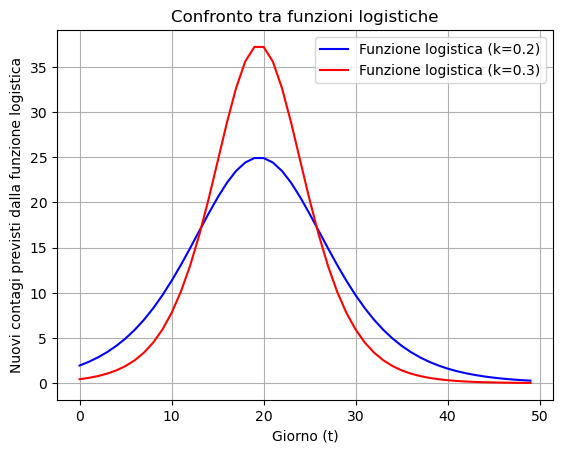

In [5]:
#Plot della funzione logistica, con due ritmi di contagio leggermente diversi e su uno stesso grafico


# Creiamo il dominio della funzione che plotteremo
valori_t = list(range(50))


# Dati iniziali
A = 500
k1 = 0.2
k2 = 0.3
t0 = 20

# Calcola i nuovi contagi per entrambe le funzioni logistiche
logistica_t_1 = [nuovi_contagi_logistica(t, A, k1, t0) for t in valori_t]
logistica_t_2 = [nuovi_contagi_logistica(t, A, k2, t0) for t in valori_t]

# Plottiamo entrambe le funzioni
plt.plot(valori_t, logistica_t_1, label="Funzione logistica (k=0.2)", color="blue")
plt.plot(valori_t, logistica_t_2, label="Funzione logistica (k=0.3)", color="red")

plt.xlabel('Giorno (t)')
plt.ylabel('Nuovi contagi previsti dalla funzione logistica')
plt.title('Confronto tra funzioni logistiche')
plt.grid(True)
plt.legend()
plt.show()

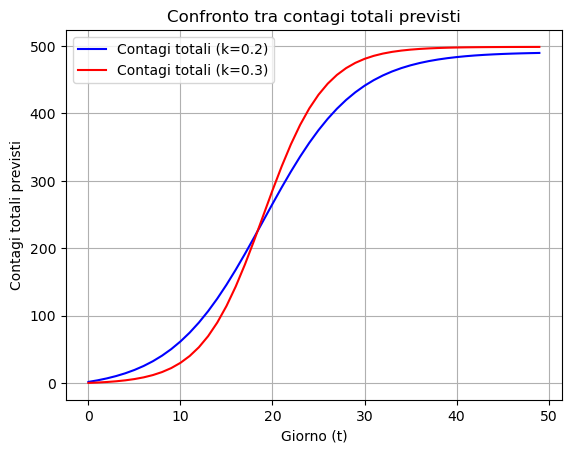

'notiamo che il problema di questa funzione è che non tiene conto di chi potrebbe guarire'

In [6]:
# Calcola i contagiati totali
contagi_totali_1 = np.cumsum(logistica_t_1)
contagi_totali_2 = np.cumsum(logistica_t_2)

# Plottiamo i contagiati totali
plt.plot(valori_t, contagi_totali_1, label="Contagi totali (k=0.2)", color="blue")
plt.plot(valori_t, contagi_totali_2, label="Contagi totali (k=0.3)", color="red")
plt.xlabel('Giorno (t)')
plt.ylabel('Contagi totali previsti')
plt.title('Confronto tra contagi totali previsti')
plt.grid(True)
plt.legend()
plt.show()

'''notiamo che il problema di questa funzione è che non tiene conto di chi potrebbe guarire'''

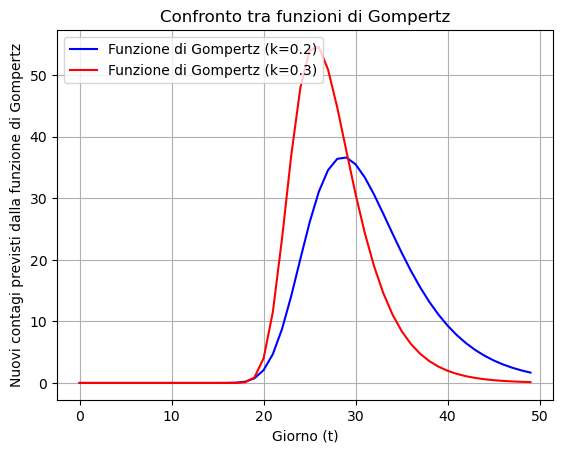

In [7]:
#Ripetiamo lo stesso procedimento con gli stessi parametri ma con la funzione di Gompertz


# Calcola i nuovi contagi per entrambe le funzioni di gompertz
gompertz_t_1 = [nuovi_contagi_gompertz(t, A, k1, t0) for t in valori_t]
gompertz_t_2 = [nuovi_contagi_gompertz(t, A, k2, t0) for t in valori_t]

# Plottiamo entrambe le funzioni
plt.plot(valori_t, gompertz_t_1, label="Funzione di Gompertz (k=0.2)", color="blue")
plt.plot(valori_t, gompertz_t_2, label="Funzione di Gompertz (k=0.3)", color="red")

plt.xlabel('Giorno (t)')
plt.ylabel('Nuovi contagi previsti dalla funzione di Gompertz')
plt.title('Confronto tra funzioni di Gompertz')
plt.grid(True)
plt.legend()
plt.show()

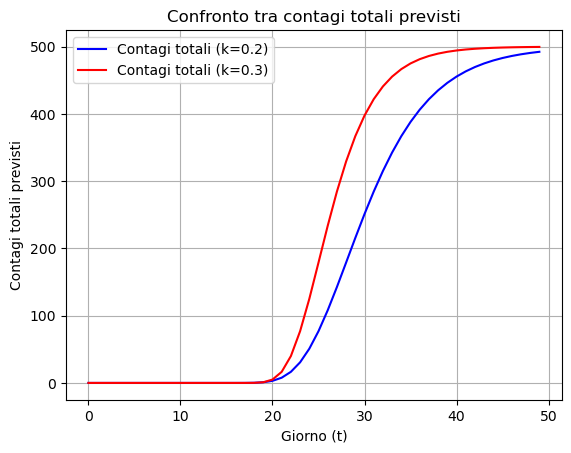

In [8]:
# Calcola i contagiati totali
contagi_totali_1 = np.cumsum(gompertz_t_1)
contagi_totali_2 = np.cumsum(gompertz_t_2)

# Plottiamo i contagiati totali
plt.plot(valori_t, contagi_totali_1, label="Contagi totali (k=0.2)", color="blue")
plt.plot(valori_t, contagi_totali_2, label="Contagi totali (k=0.3)", color="red")
plt.xlabel('Giorno (t)')
plt.ylabel('Contagi totali previsti')
plt.title('Confronto tra contagi totali previsti')
plt.grid(True)
plt.legend()
plt.show()

I nuovi contagi e le funzioni sembrano in linea con quanto aspettato. 
E' utile capire bene la differenza tra i due modelli matematici.


## Analisi Bayesiana: Prior e Posterior

L'analisi bayesiana è un approccio statistico che si basa sulla teoria delle probabilità bayesiana. In breve, l'analisi bayesiana coinvolge i seguenti passaggi:

1. **Definizione della Prior Distribution (Distribuzione a Priori)**:
    - La prior distribution rappresenta le tue convinzioni soggettive riguardo ai parametri del modello prima di osservare i dati.
    - È una distribuzione di probabilità che incorpora ciò che già sai o credi riguardo al problema.
    - La prior può essere basata su conoscenze pregresse, esperienze o informazioni di esperti.
    - Una prior informata è basata su evidenze o dati precedenti, mentre una prior non informata è più neutrale e uniforme (Come in questo caso).

2. **Calcolo della Likelihood (Verosimiglianza)**:
    - La likelihood rappresenta la probabilità di osservare i dati dati con i parametri del modello.
    - È una funzione che misura quanto i dati supportano i valori specifici dei parametri ipotizzati.
    - La likelihood è basata sulla distribuzione dei dati e sul modello statistico scelto.

3. **Calcolo del Posterior Distribution (Distribuzione a Posteriori)**:
    - Il posterior distribution rappresenta la distribuzione di probabilità dei parametri del modello dopo aver osservato i dati.
    - È ottenuto combinando la prior con la likelihood utilizzando il teorema di Bayes:

    $\text{Posterior} \propto \text{Prior} \times \text{Likelihood}$

    - Il posterior riflette l'aggiornamento delle tue convinzioni in base ai dati osservati.
    - È la distribuzione di probabilità che vuoi utilizzare per fare previsioni o inferenze.


4. **Analisi del Posterior**:
    - Esaminando il posterior, si possono ottenere stime puntuali o intervalli di confidenza per i parametri del modello.
    - Puoi anche confrontare diverse ipotesi o modelli utilizzando il posterior (Astrofisica, impossibilità di ripetere situazioni)
    
    
    # Analisi dei primi 35 giorni di pandemia

I primi 35 giorni di pandemia sono stati abbastanza uniformi in termini di contagiosità. Una volta scoperto il virus, sono state attuate misure di contenimento che non sono cambiate radicalmente in questo primo periodo. Alcune differenze sono state il cambio del tipo di mascherina necessario e la definizione di cosa si potesse e non potesse fare.

La nostra analisi sarà di tipo **sequenziale bayesiana**, nel senso che useremo questa parte di dati per raccogliere informazioni e creare un posterior del ritmo di contagio, che a sua volta diventerà prior di un intervallo temporale più ampio. In realtà, ci limiteremo a verificare che il posterior vada bene con un'analisi qualitativa dei grafici, grazie alla quale accetteremo o rigetteremo le ipotesi formulate.

I prior utilizzati sono **uniformi** sui valori dei parametri, in quanto pareva una buona scelta in assenza di informazioni epidemiologiche particolari. La likelihood usata è a **distribuzione poissoniana**. 

Di seguito sono riportati tutti i grafici ricavati.

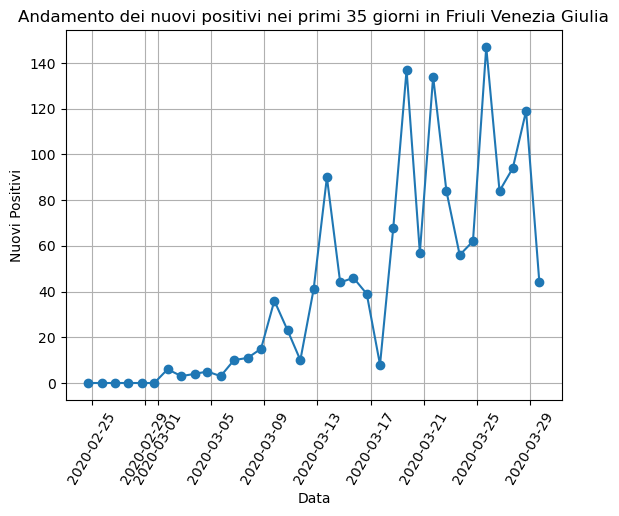

In [9]:
#Prendo i dati dei primi 35 giorni di contagio

'''Iniziamo a studiare l andamento dei primi 35 giorni di contagio'''
#Limita l'insieme dei dati ai primi 35 giorni
df_fvg_35 = df_fvg.head(35)

# Plotta
plt.plot(df_fvg_35['data'], df_fvg_35['nuovi_positivi'], marker='o')
plt.xlabel('Data')
plt.ylabel('Nuovi Positivi')
plt.title('Andamento dei nuovi positivi nei primi 35 giorni in Friuli Venezia Giulia')
plt.xticks(rotation=60)
plt.grid(True)
plt.show()

C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 109.39it/s]


[1.91222164e+03 2.08412377e-01 2.89948915e+01]
[[-7.06282930e+01 -7.51363707e-03 -3.80790183e-01]
 [ 7.01740522e+01  7.45670620e-03  3.81825474e-01]]


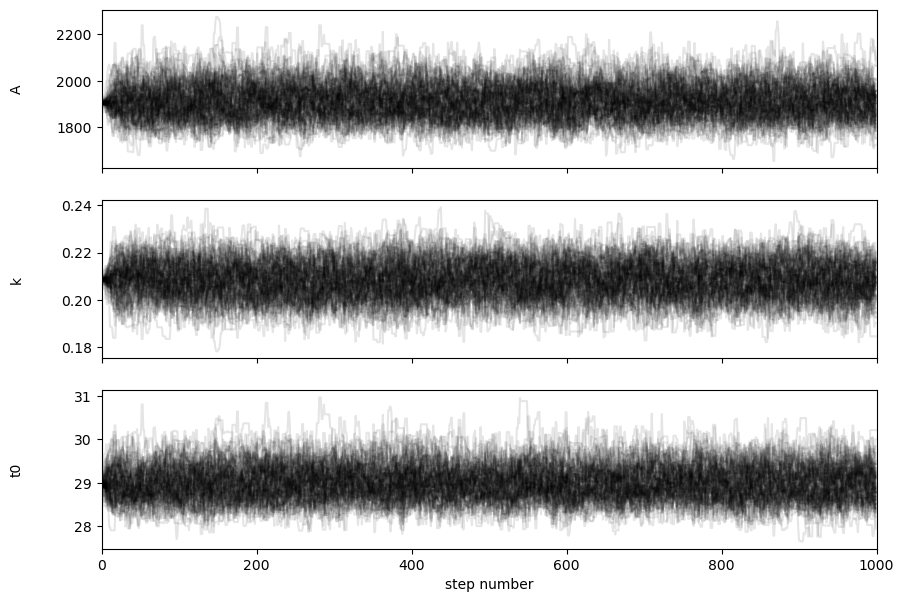

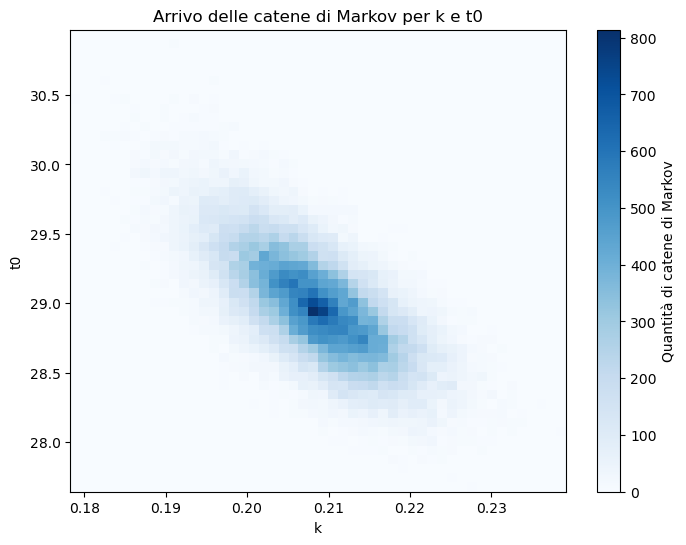

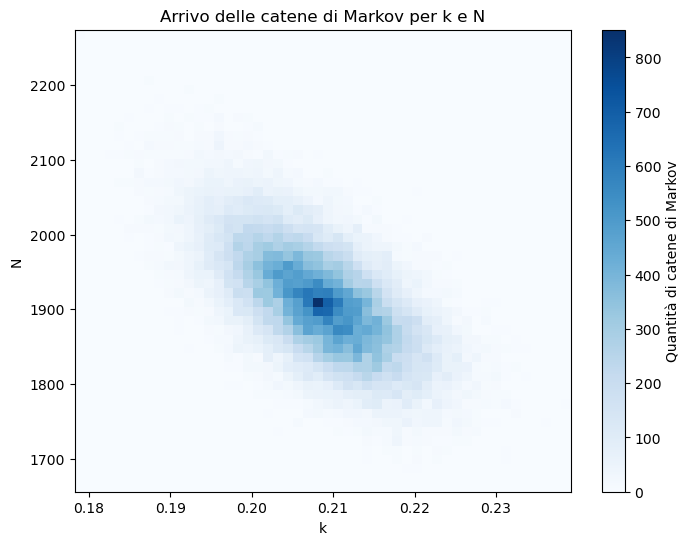

In [10]:
# Come prima, osserviamo i primi 35 giorni
t = np.arange(0, 35, 1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()

# Definiamo la funzione di log-likelihood della distribuzione di Poisson rispetto alla funzione logistica
def log_likelihood(params, t, osservati):
    A, k, t0 = params
    predetti = np.array([nuovi_contagi_logistica(i, A, k, t0) for i in t])
    log_likelihood = np.sum((-predetti) + osservati * np.log(predetti) - np.log(gamma(osservati.astype(int) + 1)))
    return log_likelihood



# la funzione log-prior, definendo anche i casi limite
def log_prior(params):
    A, k, t0 = params
    if 0 < A < 5000 and 0 < k < 10 and 0 < t0 < 35:
        return 0
    return -np.inf

# la funzione log-posterior, definendo anche i casi limite
def log_posterior(params, t, osservati):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Definiamo grazie a lambda la funzione da minimizzare
NegLL = lambda *args: -log_posterior(*args)

# Parametri Di Partenza

A_0 = np.sum(Nosservati)
k_0 = 1.6
t0_0 = 20
parametri_0 = [A_0, k_0, t0_0]


# Ottimizziamo col modulo scy.py la funzione da minimizzare
result = minimize(NegLL, parametri_0, args=(t, Nosservati))
A_1, k_1, t0_1 = result.x

# Scegliamo gli walker
ndim = 3
nwalkers = 100
pos = result.x * (1 + 1e-3 * np.random.randn(nwalkers, ndim))

# Avviamo l'algoritmo
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, Nosservati))
sampler.run_mcmc(pos, 1000, progress=True)

# Creazione del grafico
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "k", "t0"]

# Plot le catene di Markov
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Supponendo andamenti gaussiani calcoliamo anche le incertezze
Stima_L = np.mean(samples, axis=(0, 1))
Errore_L = np.percentile(samples, [16, 84], axis=(0, 1)) - Stima_L

print(Stima_L)
print(Errore_L)


# Estrai i valori di arrivo delle catene di Markov per k e t0
k_values = sampler.get_chain()[:, :, 1].flatten()
t0_values = sampler.get_chain()[:, :, 2].flatten()

# Crea il grafico 2D
plt.figure(figsize=(8, 6))
plt.hist2d(k_values, t0_values, bins=50, cmap="Blues")
plt.colorbar(label="Quantità di catene di Markov")
plt.xlabel("k")
plt.ylabel("t0")
plt.title("Arrivo delle catene di Markov per k e t0")
plt.show()

# Estrai i valori di arrivo delle catene di Markov per k e N
k_values = sampler.get_chain()[:, :, 1].flatten()
N_values = sampler.get_chain()[:, :, 0].flatten()

# Crea il grafico 2D
plt.figure(figsize=(8, 6))
plt.hist2d(k_values, N_values, bins=50, cmap="Blues")
plt.colorbar(label="Quantità di catene di Markov")
plt.xlabel("k")
plt.ylabel("N")
plt.title("Arrivo delle catene di Markov per k e N")
plt.show()

C:\Users\Matteo\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.39it/s]


[3.22347272e+03 7.76010210e-02 4.69742447e+00]
[[-2.47623770e+02 -4.17184404e-03 -6.41057270e-01]
 [ 2.47569666e+02  4.14380716e-03  6.36092217e-01]]


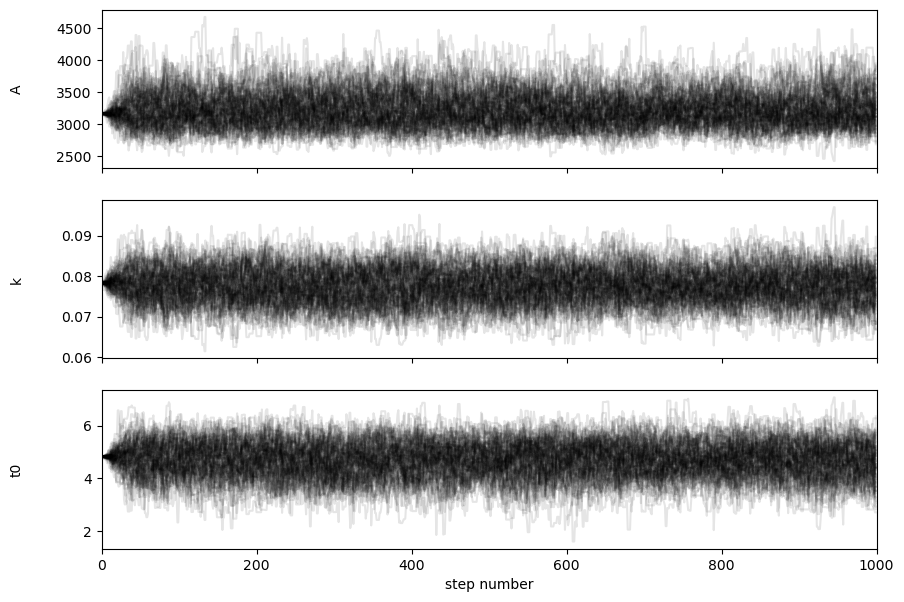

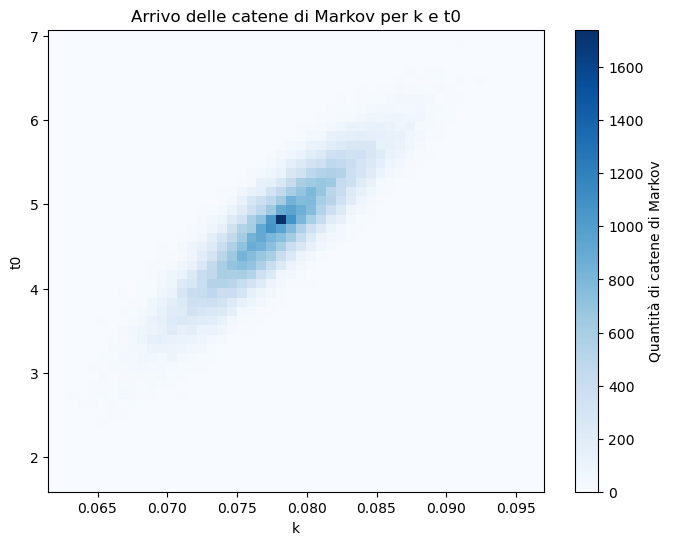

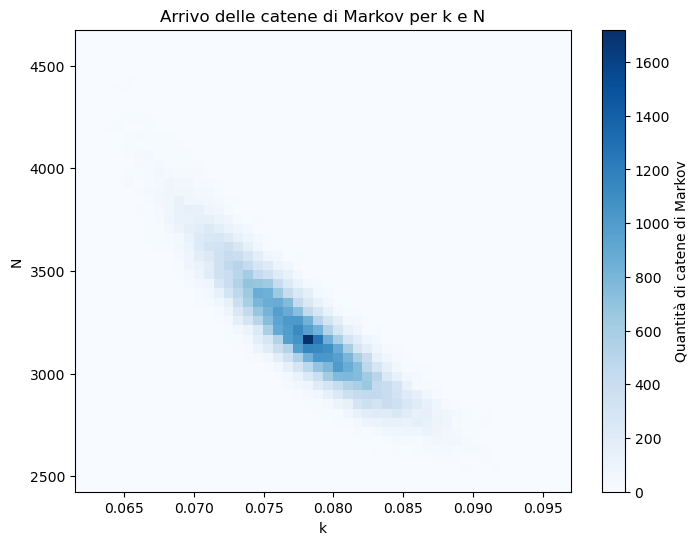

In [11]:
# Come prima, osserviamo i primi 35 giorni
t = np.arange(0, 35, 1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()

# Definiamo la funzione di log-likelihood della distribuzione di Poisson rispetto alla funzione logistica
def log_likelihood(params, t, osservati):
    A, k, t0 = params
    predetti = np.array([nuovi_contagi_gompertz(i, A, k, t0) for i in t])
    log_likelihood = np.sum((-predetti) + osservati * np.log(predetti) - np.log(gamma(osservati.astype(int) + 1)))
    return log_likelihood



# la funzione log-prior, definendo anche i casi limite
def log1_prior(params):
    A, k, t0 = params
    if 0 < A < 5000 and 0 < k < 10 and 0 < t0 < 35:
        return 0
    return -np.inf

# la funzione log-posterior, definendo anche i casi limite
def log_posterior(params, t, osservati):
    lp = log1_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, t, osservati)


# Definiamo grazie a lambda la funzione da minimizzare
NegLL = lambda *args: -log_posterior(*args)

# Parametri Di Partenza

A_0 = np.sum(Nosservati)
k_0 = 0.2
t0_0 = 20
parametri_0 = [A_0, k_0, t0_0]


# Ottimizziamo col modulo scy.py la funzione da minimizzare
result = minimize(NegLL, parametri_0, args=(t, Nosservati))
A_1, k_1, t0_1 = result.x

# Scegliamo gli walker
ndim = 3
nwalkers = 100
pos = result.x * (1 + 1e-3 * np.random.randn(nwalkers, ndim))

# Avviamo l'algoritmo
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(t, Nosservati))
sampler.run_mcmc(pos, 1000, progress=True)

# Creazione del grafico
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "k", "t0"]

# Plot delle catene di Markov
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#Calcolo dei parametri stimati
Stima_G = np.mean(samples, axis=(0, 1))
Errore_G = np.percentile(samples, [16, 84], axis=(0, 1)) - Stima_G

print(Stima_G)
print(Errore_G)


# Estrai i valori di arrivo delle catene di Markov per k e t0
k_values = sampler.get_chain()[:, :, 1].flatten()
t0_values = sampler.get_chain()[:, :, 2].flatten()

# Crea il grafico 2D
plt.figure(figsize=(8, 6))
plt.hist2d(k_values, t0_values, bins=50, cmap="Blues")
plt.colorbar(label="Quantità di catene di Markov")
plt.xlabel("k")
plt.ylabel("t0")
plt.title("Arrivo delle catene di Markov per k e t0")
plt.show()

# Estrai i valori di arrivo delle catene di Markov per k e N
k_values = sampler.get_chain()[:, :, 1].flatten()
N_values = sampler.get_chain()[:, :, 0].flatten()

# Crea il grafico 2D
plt.figure(figsize=(8, 6))
plt.hist2d(k_values, N_values, bins=50, cmap="Blues")
plt.colorbar(label="Quantità di catene di Markov")
plt.xlabel("k")
plt.ylabel("N")
plt.title("Arrivo delle catene di Markov per k e N")
plt.show()

Parametri funzione Logistica:
A = 1912.2216403993846
k = 0.20841237679808036
t0 = 28.994891535022663

Parametri funzione di Gompertz:
A = 3223.4727188546103
k = 0.07760102098478953
t0 = 4.697424470498899


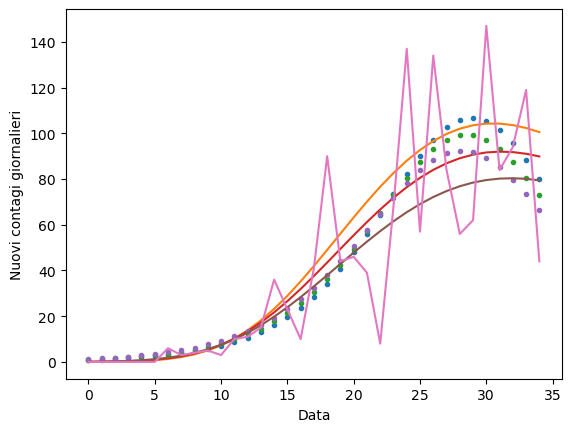

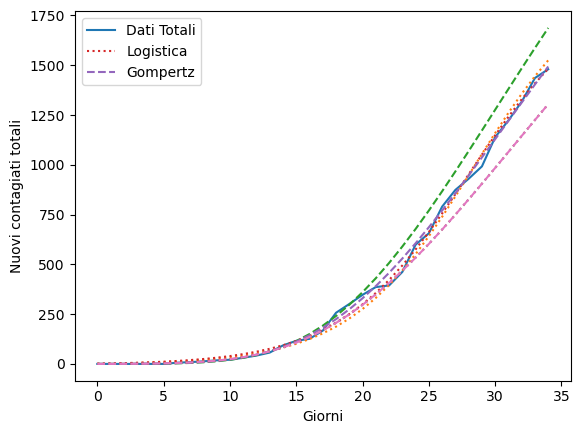

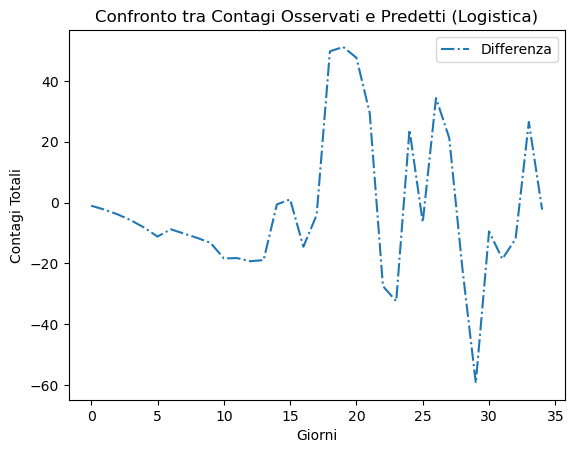

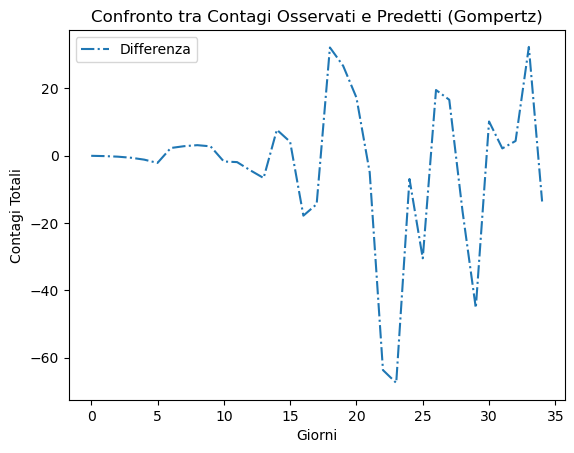

In [12]:
t = np.arange(0, 35,1)  # con 35 giorni
Nosservati = df_fvg.head(35)['nuovi_positivi'].to_numpy()
NosservatiTOT = np.cumsum(Nosservati)

# Parametri stimati + una deviazione standard
NLP = Stima_L[0] + Errore_L[1, 0]
KLP = Stima_L[1] + Errore_L[1, 1]
TLP = Stima_L[2] + Errore_L[1, 2]

NGP = Stima_G[0] + Errore_G[1, 0]
KGP = Stima_G[1] + Errore_G[1, 1]
TGP = Stima_G[2] + Errore_G[1, 2]

YLP = nuovi_contagi_logistica(t, NLP, KLP, TLP)
YGP = nuovi_contagi_gompertz(t, NGP, KGP, TGP)

plt.plot(t, (YLP), '.')
plt.plot(t, (YGP), '-')


# Parametri stimati

NL=Stima_L[0]
KL=Stima_L[1]
TL=Stima_L[2]

NG=Stima_G[0]
KG=Stima_G[1]
TG=Stima_G[2]

YL=nuovi_contagi_logistica(t, NL, KL, TL)
YG=nuovi_contagi_gompertz(t, NG, KG, TG)

plt.plot(t, (YL), '.')
plt.plot(t, (YG), '-')





#Parametri stimati - una deviazione standard

NLM=Stima_L[0]+Errore_L[0,0]
KLM=Stima_L[1]+Errore_L[0,1]
TLM=Stima_L[2]+Errore_L[0,2]

NGM=Stima_G[0]+Errore_G[0,0]
KGM=Stima_G[1]+Errore_G[0,1]
TGM=Stima_G[2]+Errore_G[0,2]

YLM=nuovi_contagi_logistica(t, NLM, KLM, TLM)
YGM=nuovi_contagi_gompertz(t, NGM, KGM, TGM)

plt.plot(t, (YLM), '.')
plt.plot(t, (YGM), '-')


#Mostriamo i parametri

print("Parametri funzione Logistica:")
print("A =", NL)
print("k =", KL)
print("t0 =", TL)

print("\nParametri funzione di Gompertz:")
print("A =", NG)
print("k =", KG)
print("t0 =", TG)




#Qui plottiamo il grafico
plt.plot(t, Nosservati)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


YLPTOT = np.cumsum(YLP[:35])
YGPTOT = np.cumsum(YGP[:35])
YLTOT = np.cumsum(YL[:35])
YGTOT = np.cumsum(YG[:35])
YGMTOT = np.cumsum(YGM[:35])
YGMTOT = np.cumsum(YGM[:35])

# Plot dei dati e delle funzioni
plt.plot(t, NosservatiTOT, label="Dati Totali")

# SOPRA
plt.plot(t, YLPTOT, linestyle="dotted")
plt.plot(t, YGPTOT, linestyle="--")

# CENTRO
plt.plot(t, YLTOT, label="Logistica", linestyle="dotted")
plt.plot(t, YGTOT, label="Gompertz", linestyle="--")

# SOTTO
plt.plot(t, YGMTOT, linestyle="dotted")
plt.plot(t, YGMTOT, linestyle="--")

plt.xlabel("Giorni")
plt.ylabel("Nuovi contagiati totali")
plt.legend()
plt.show()

# Calcolo dei contagi predetti dalla funzione logistica
YLP = nuovi_contagi_logistica(t, NL, KL, TL)
YLP_TOT = np.cumsum(YLP[:35])

# Calcolo della differenza tra osservati e predetti
differenza = NosservatiTOT - YLP_TOT

# Grafico dei contagi osservati, predetti e la loro differenza
plt.plot(t, differenza, linestyle="-.", label="Differenza")
plt.xlabel("Giorni")
plt.ylabel("Contagi Totali")
plt.legend()
plt.title("Confronto tra Contagi Osservati e Predetti (Logistica)")
plt.show()


# Calcolo dei contagi predetti dalla funzione di Gompertz
YGP = nuovi_contagi_gompertz(t, NG, KG, TG)
YGP_TOT = np.cumsum(YGP[:35])

# Calcolo della differenza tra osservati e predetti
differenzaG = NosservatiTOT - YGP_TOT

# Grafico dei contagi osservati, predetti e la loro differenza
plt.plot(t, differenzaG, linestyle="-.", label="Differenza")
plt.xlabel("Giorni")
plt.ylabel("Contagi Totali")
plt.legend()
plt.title("Confronto tra Contagi Osservati e Predetti (Gompertz)")
plt.show()

Parametri funzione Logistica:
A = 1912.2216403993846
k = 0.20841237679808036
t0 = 28.994891535022663

Parametri funzione di Gompertz:
A = 3223.4727188546103
k = 0.07760102098478953
t0 = 4.697424470498899


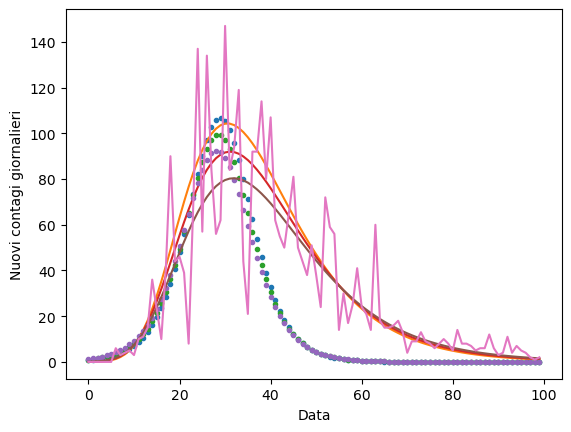

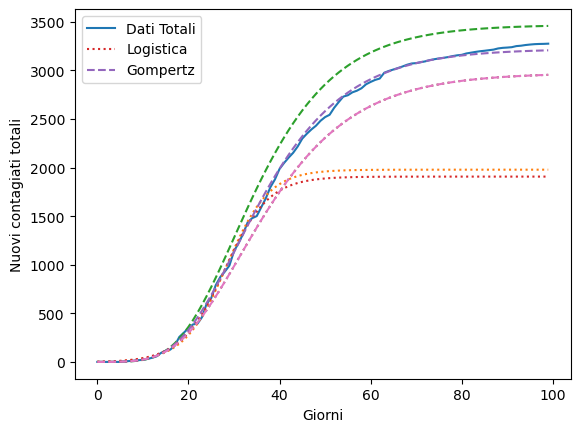

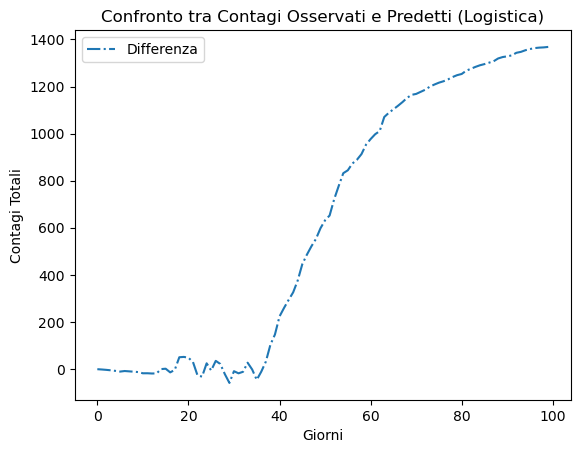

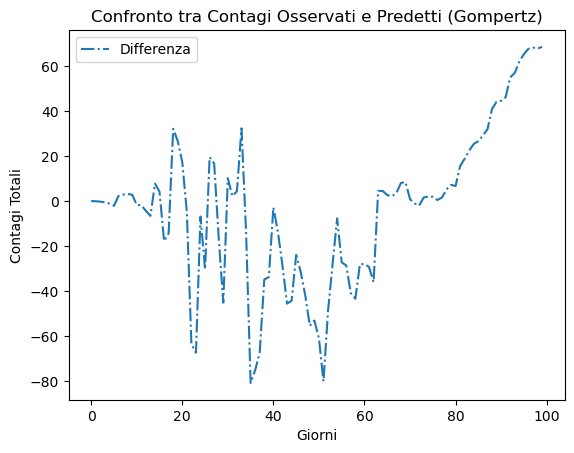

In [13]:
t = np.arange(0, 100,1)  # con 100 giorni
Nosservati = df_fvg.head(100)['nuovi_positivi'].to_numpy()
NosservatiTOT = np.cumsum(Nosservati)

# Parametri stimati + una deviazione standard
NLP = Stima_L[0] + Errore_L[1, 0]
KLP = Stima_L[1] + Errore_L[1, 1]
TLP = Stima_L[2] + Errore_L[1, 2]

NGP = Stima_G[0] + Errore_G[1, 0]
KGP = Stima_G[1] + Errore_G[1, 1]
TGP = Stima_G[2] + Errore_G[1, 2]

YLP = nuovi_contagi_logistica(t, NLP, KLP, TLP)
YGP = nuovi_contagi_gompertz(t, NGP, KGP, TGP)

plt.plot(t, (YLP), '.')
plt.plot(t, (YGP), '-')


# Parametri stimati

NL=Stima_L[0]
KL=Stima_L[1]
TL=Stima_L[2]

NG=Stima_G[0]
KG=Stima_G[1]
TG=Stima_G[2]

YL=nuovi_contagi_logistica(t, NL, KL, TL)
YG=nuovi_contagi_gompertz(t, NG, KG, TG)

plt.plot(t, (YL), '.')
plt.plot(t, (YG), '-')





#Parametri stimati - una deviazione standard

NLM=Stima_L[0]+Errore_L[0,0]
KLM=Stima_L[1]+Errore_L[0,1]
TLM=Stima_L[2]+Errore_L[0,2]

NGM=Stima_G[0]+Errore_G[0,0]
KGM=Stima_G[1]+Errore_G[0,1]
TGM=Stima_G[2]+Errore_G[0,2]

YLM=nuovi_contagi_logistica(t, NLM, KLM, TLM)
YGM=nuovi_contagi_gompertz(t, NGM, KGM, TGM)

plt.plot(t, (YLM), '.')
plt.plot(t, (YGM), '-')


#Mostriamo i parametri

print("Parametri funzione Logistica:")
print("A =", NL)
print("k =", KL)
print("t0 =", TL)

print("\nParametri funzione di Gompertz:")
print("A =", NG)
print("k =", KG)
print("t0 =", TG)




#Qui plottiamo il grafico
plt.plot(t, Nosservati)
plt.xlabel("Data")
plt.ylabel("Nuovi contagi giornalieri")
plt.show()


YLPTOT = np.cumsum(YLP[:100])
YGPTOT = np.cumsum(YGP[:100])
YLTOT = np.cumsum(YL[:100])
YGTOT = np.cumsum(YG[:100])
YGMTOT = np.cumsum(YGM[:100])
YGMTOT = np.cumsum(YGM[:100])

# Plot dei dati e delle funzioni
plt.plot(t, NosservatiTOT, label="Dati Totali")

# SOPRA
plt.plot(t, YLPTOT, linestyle="dotted")
plt.plot(t, YGPTOT, linestyle="--")

# CENTRO
plt.plot(t, YLTOT, label="Logistica", linestyle="dotted")
plt.plot(t, YGTOT, label="Gompertz", linestyle="--")

# SOTTO
plt.plot(t, YGMTOT, linestyle="dotted")
plt.plot(t, YGMTOT, linestyle="--")

plt.xlabel("Giorni")
plt.ylabel("Nuovi contagiati totali")
plt.legend()
plt.show()


# Calcolo dei contagi predetti dalla funzione logistica
YLP = nuovi_contagi_logistica(t, NL, KL, TL)
YLP_TOT = np.cumsum(YLP[:100])

# Calcolo della differenza tra osservati e predetti
differenza = NosservatiTOT - YLP_TOT

# Grafico dei contagi osservati, predetti e la loro differenza
plt.plot(t, differenza, linestyle="-.", label="Differenza")
plt.xlabel("Giorni")
plt.ylabel("Contagi Totali")
plt.legend()
plt.title("Confronto tra Contagi Osservati e Predetti (Logistica)")
plt.show()


# Calcolo dei contagi predetti dalla funzione di Gompertz
YGP = nuovi_contagi_gompertz(t, NG, KG, TG)
YGP_TOT = np.cumsum(YGP[:100])

# Calcolo della differenza tra osservati e predetti
differenzaG = NosservatiTOT - YGP_TOT

# Grafico dei contagi osservati, predetti e la loro differenza
plt.plot(t, differenzaG, linestyle="-.", label="Differenza")
plt.xlabel("Giorni")
plt.ylabel("Contagi Totali")
plt.legend()
plt.title("Confronto tra Contagi Osservati e Predetti (Gompertz)")
plt.show()

                    data  nuovi_positivi
0    2020-09-03 17:00:00              25
1    2020-09-04 17:00:00              23
2    2020-09-05 17:00:00              49
3    2020-09-06 17:00:00              20
4    2020-09-07 17:00:00              11
...                  ...             ...
1269 2024-02-24 17:00:00               4
1270 2024-02-25 17:00:00               1
1271 2024-02-26 17:00:00               4
1272 2024-02-27 17:00:00               3
1273 2024-02-28 17:00:00               5

[1274 rows x 2 columns]


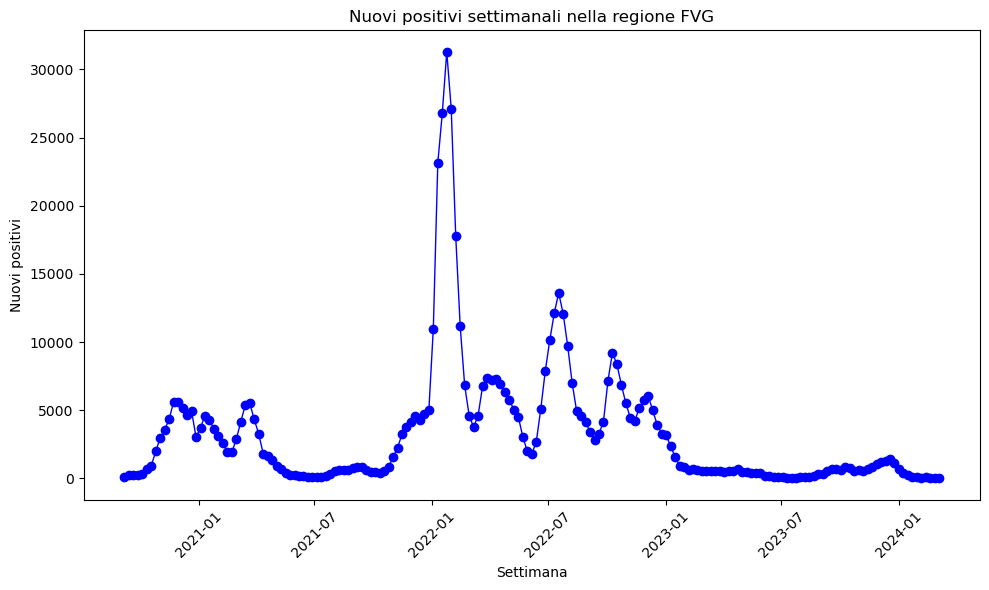

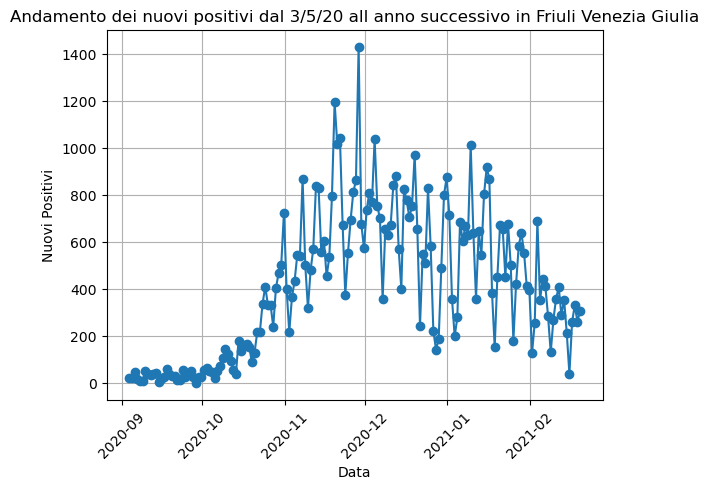

In [14]:



# Leggi il file CSV
df = pd.read_csv(r'C:\Users\Matteo\Desktop\Dati1.csv')

# Filtra i dati solo per la regione FVG
df_fvg = df[df['denominazione_regione'] == 'Friuli Venezia Giulia']

# Ordina i dati per data
df_fvg = df_fvg.sort_values(by='data')

# Seleziona solo le colonne di interesse
df_fvg = df_fvg[['data', 'nuovi_positivi']]

# Definisci la data di inizio analisi
start_date = '2020-09-03'

# Filtra i dati a partire dalla data di interesse
df_fvg = df_fvg[df_fvg['data'] >= start_date]

# Reset dell'indice
df_fvg = df_fvg.reset_index(drop=True)

# Converti la colonna 'data' in formato datetime
df_fvg['data'] = pd.to_datetime(df_fvg['data'])

# Stampa il DataFrame risultante
print(df_fvg)

# Raggruppa i dati per settimana e calcola la somma dei nuovi positivi
df_weekly = df_fvg.resample('W-Mon', on='data').sum()

# Plot a linee e punti per dati settimanali
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['nuovi_positivi'], marker='o', linestyle='-', color='blue', linewidth=1)
plt.title('Nuovi positivi settimanali nella regione FVG')
plt.xlabel('Settimana')
plt.ylabel('Nuovi positivi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Limita ai primi 170 giorni
df_fvg_365 = df_fvg.head(170)

# Plot dei dati
plt.plot(df_fvg_365['data'], df_fvg_365['nuovi_positivi'], marker='o')
plt.xlabel('Data')
plt.ylabel('Nuovi Positivi')
plt.title('Andamento dei nuovi positivi dal 3/5/20 all anno successivo in Friuli Venezia Giulia')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Analisi dati dal 3 giugno 2020 al 3 giugno 2021

Tratte le opportune conclusioni dalle analisi precedenti, risulta più opportuno utilizzare un **modello di Gompertz**, in quanto rappresenta meglio la diffusione epidemica.
Notiamo come questa epidemia sia composta da due picchi, da cui la necessità di supporre due diverse epidemie e sommarle.

**vantaggi modello di Gompertz**:
1. Ricavare dei parametri soddisfacenti è relativamente efficente,
2. Facilità di interpretazione dei dati in un intervallo così ampio,
3. Decessi e guarigioni sono ragionevolmente approssimate, 

**svantaggi modello di Gompertz**
1. La diffusione epidemica non è stata uniforme, per via delle diverse misure di contenimento,
2. Questo modello è pur sempre un approssimazione, soprattutto dei decessi e delle guarigioni,
3. Questo modello non fornisce facilmente informazioni circa le misure di contenimento da adottare.

**Possibile alternativa**:
Un modello alternativo ma efficace che permetterebbe di approssimare molto meno l'epidemia e di capire quando adottare le misure di contenimento è il **modello SIS**:

Il **modello SIS** è uno dei modelli epidemiologici più semplici. Si applica a malattie per le quali non sviluppiamo immunità permanente dopo averle contratte, quindi è possibile prenderle più volte.

Il modello SIS descrive il flusso di individui tra due classi epidemiologiche: **S** (suscettibili), e **I** (infette). Le ipotesi principali del modello sono:

   - La popolazione totale, N, è fissa.
   - Il tasso di trasmissione della malattia da individui infetti a suscettibili è rappresentato da **β**.
   - Il tasso di guarigione delle persone infette è rappresentato da **γ**.

Anche qui, il modello SIS dovrebbe essere diviso in più intervalli temporali.

Il modello SIS è descritto dall'equazione differenziale:

$${dI}/{dt} = βSI - γI $$

Dove:
- $I$ è il numero di persone infette.
- $S$ è il numero di persone suscettibili.
- $t$ è il tempo.